# Correlation lengths

Created 17/07/2024

Objectives:
* Write a function to calculate the correlation length of an MPS

# Imports

In [1]:
from functools import reduce

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [4]:
import h5py
from tenpy.tools import hdf5_io

import os

In [5]:
import sys

In [6]:
sys.path.append("../")

In [7]:
from SPTOptimization.utils import (
    get_transfer_matrix_from_unitary,
    multiply_transfer_matrices
)

In [79]:
import pickle

# Load data

In [8]:
DATA_DIR = r"data/transverse_cluster_200_site_dmrg"

In [9]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [10]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [11]:
psi_dict = dict()

In [12]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Initial tests

In [13]:
test_psi = psi_dict[0.5]

In [14]:
test_tm = (
    get_transfer_matrix_from_unitary(test_psi, 100)
    .combine_legs([['vR', 'vR*'], ['vL', 'vL*']])
    .to_ndarray()
)

In [15]:
np.linalg.eigvals(test_tm)

array([ 1.        +3.60141469e-17j,  0.99262633-6.43718570e-18j,
       -0.81667963+2.24548548e-17j,  0.68165188+5.41470732e-17j,
       -0.81671761+1.92126797e-17j, -0.4358438 +6.85323242e-17j,
       -0.33571146+3.30035610e-17j, -0.44737044-2.67301183e-17j,
        0.31360024-1.12802090e-16j, -0.31183672-2.13033102e-16j,
        0.31380393-1.17506425e-16j, -0.19414252+9.44187440e-17j,
        0.13678232+1.27679054e-01j,  0.18772291+7.54390635e-02j,
        0.2177274 +7.14693093e-03j,  0.2177274 -7.14693093e-03j,
        0.18772291-7.54390635e-02j,  0.13678232-1.27679054e-01j,
       -0.21104775+2.90223900e-18j, -0.15643413-2.93153936e-17j,
        0.21747391+2.08350201e-02j,  0.21747391-2.08350201e-02j,
       -0.05280738+1.10858427e-01j, -0.05280738-1.10858427e-01j,
       -0.15323067+4.06188101e-17j,  0.07248865+7.00305261e-02j,
        0.07248865-7.00305261e-02j, -0.08620203-6.27040571e-17j,
       -0.04515352+9.17770207e-02j, -0.04515352-9.17770207e-02j,
       -0.07339911+4.3091

In [16]:
-1/np.log(0.99262633)

135.11706074443174

In [17]:
test_tms = [
    get_transfer_matrix_from_unitary(p, 100)
    .combine_legs([['vR', 'vR*'], ['vL', 'vL*']])
    .to_ndarray()
    for p in psi_dict.values()
]

In [18]:
def get_corr_length(tm):
    eigs = np.linalg.eigvals(tm)
    l2 = np.abs(eigs[1])
    return -1/np.log(l2)

In [19]:
test_corr_lengths = [get_corr_length(tm) for tm in test_tms]

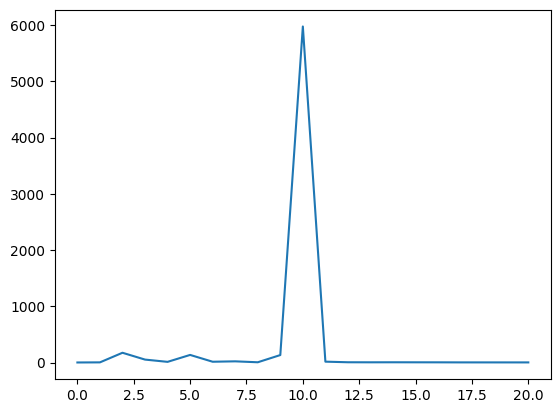

In [20]:
plt.plot(test_corr_lengths)

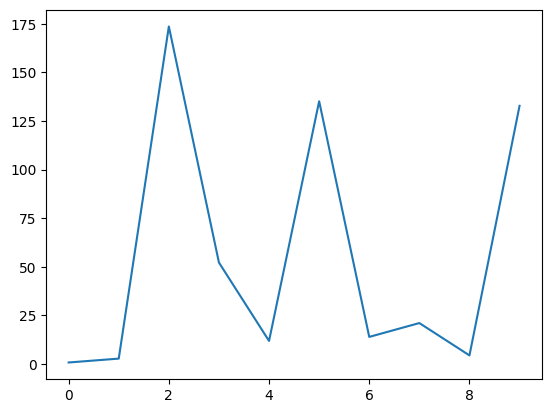

In [21]:
plt.plot(test_corr_lengths[:10])

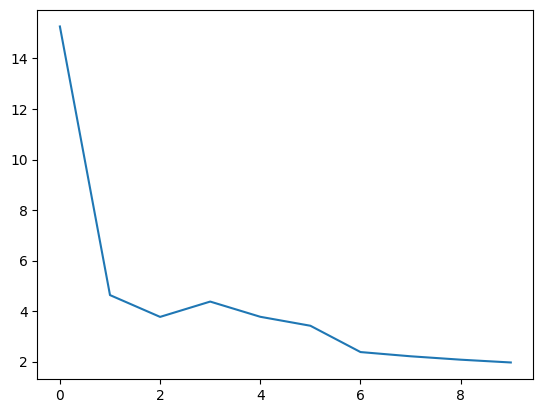

In [22]:
plt.plot(test_corr_lengths[11:])

In [23]:
test_psi.L

200

In [24]:
def get_cental_transfer_matrix(psi, num_sites=40):
    total_num_sites = psi.L

    left_site = (total_num_sites - num_sites)//2

    transfer_matrices = (
        get_transfer_matrix_from_unitary(psi, i)
        for i in range(left_site, left_site + num_sites)
    )

    overall_transfer_matrix = reduce(multiply_transfer_matrices, transfer_matrices)

    return overall_transfer_matrix

In [25]:
def get_corr_length(tm, num_sites=40):
    np_tm = (
        tm
        .combine_legs([['vR', 'vR*'], ['vL', 'vL*']])
        .to_ndarray()
    )

    eigs = np.sort(np.linalg.eigvals(np_tm))[::-1]
    l2 = np.abs(eigs[1])
    return np.array([-num_sites/np.log(l2), eigs[0]])

In [26]:
num_sites=60

In [27]:
test_big_tms = [
    get_cental_transfer_matrix(p, num_sites)
    for p in psi_dict.values()
]

In [28]:
test_big_corr_lengths = np.array([
    get_corr_length(tm, num_sites)
    for tm in test_big_tms
])

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


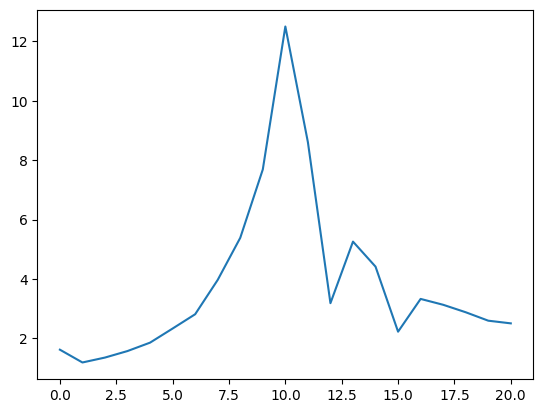

In [29]:
plt.plot(test_big_corr_lengths[:,0])

In [30]:
test_big_corr_lengths[:,1]

array([1.+0.00000000e+000j, 1.+0.00000000e+000j, 1.+0.00000000e+000j,
       1.+0.00000000e+000j, 1.+0.00000000e+000j, 1.+0.00000000e+000j,
       1.+0.00000000e+000j, 1.+0.00000000e+000j, 1.+0.00000000e+000j,
       1.+0.00000000e+000j, 1.-7.71462980e-103j, 1.+0.00000000e+000j,
       1.-8.60957776e-042j, 1.-4.48415509e-044j, 1.+5.60519386e-045j,
       1.+0.00000000e+000j, 1.+0.00000000e+000j, 1.+0.00000000e+000j,
       1.+0.00000000e+000j, 1.+0.00000000e+000j, 1.-3.26265223e-055j])

In [31]:
test_big_corr_lengths

array([[ 1.61797575+0.00000000e+000j,  1.        +0.00000000e+000j],
       [ 1.18701537+0.00000000e+000j,  1.        +0.00000000e+000j],
       [ 1.35257822+0.00000000e+000j,  1.        +0.00000000e+000j],
       [ 1.57227909+0.00000000e+000j,  1.        +0.00000000e+000j],
       [ 1.85519453+0.00000000e+000j,  1.        +0.00000000e+000j],
       [ 2.3300337 +0.00000000e+000j,  1.        +0.00000000e+000j],
       [ 2.81144211+0.00000000e+000j,  1.        +0.00000000e+000j],
       [ 3.96757482+0.00000000e+000j,  1.        +0.00000000e+000j],
       [ 5.3846893 +0.00000000e+000j,  1.        +0.00000000e+000j],
       [ 7.68616093+0.00000000e+000j,  1.        +0.00000000e+000j],
       [12.5003699 +0.00000000e+000j,  1.        -7.71462980e-103j],
       [ 8.60528635+0.00000000e+000j,  1.        +0.00000000e+000j],
       [ 3.18356514+0.00000000e+000j,  1.        -8.60957776e-042j],
       [ 5.25663816+0.00000000e+000j,  1.        -4.48415509e-044j],
       [ 4.41405736+0.00000000e+00

Text(0.5, 1.0, 'Correlation length in the ZXZ model as a function of B')

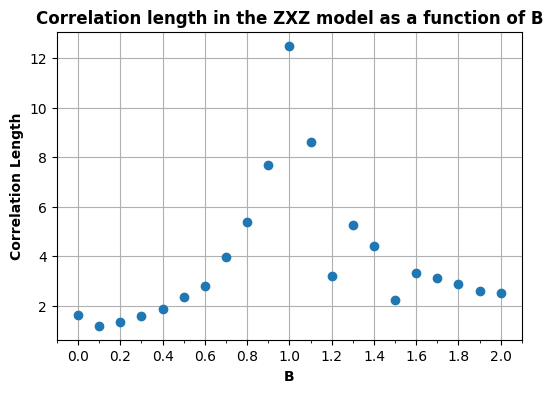

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    psi_dict.keys(),
    test_big_corr_lengths[:,0],
    'o'
)

ax.grid()

ax.set_xticks(np.array(list(psi_dict.keys())))

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlabel("B", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.set_title("Correlation length in the ZXZ model as a function of B", fontweight='bold')

In [33]:
test_big_corr_lengths[:,0]

array([ 1.61797575+0.j,  1.18701537+0.j,  1.35257822+0.j,  1.57227909+0.j,
        1.85519453+0.j,  2.3300337 +0.j,  2.81144211+0.j,  3.96757482+0.j,
        5.3846893 +0.j,  7.68616093+0.j, 12.5003699 +0.j,  8.60528635+0.j,
        3.18356514+0.j,  5.25663816+0.j,  4.41405736+0.j,  2.22385986+0.j,
        3.32706714+0.j,  3.12969471+0.j,  2.87809319+0.j,  2.5941129 +0.j,
        2.5039303 +0.j])

In [34]:
tp_tm = test_big_tms[0]

In [35]:
tp_tm

<npc.Array shape=(2, 2, 2, 2) labels=['vL', 'vL*', 'vR', 'vR*']>

In [36]:
np_tm = (
    tp_tm
    .combine_legs([['vR', 'vR*'], ['vL', 'vL*']])
    .to_ndarray()
)

eigs = np.linalg.eigvals(np_tm)

In [37]:
eigs

array([7.85046229e-17+0.j, 1.00000000e+00+0.j, 3.75058810e-48+0.j,
       0.00000000e+00+0.j])

In [38]:
np.sort(eigs)[::-1]

array([1.00000000e+00+0.j, 7.85046229e-17+0.j, 3.75058810e-48+0.j,
       0.00000000e+00+0.j])

# From X expectation values

In [39]:
total_num_sites = 200
num_sites = 40

In [40]:
left_site = (total_num_sites - num_sites)//2
right_site = left_site + num_sites
(left_site, right_site)

(80, 120)

In [41]:
test_psi.expectation_value('Sx', [left_site, right_site])

array([0.12932601, 0.12932601])

In [42]:
x_exps = np.array([
    psi.expectation_value('Sx') for psi in psi_dict.values()
])

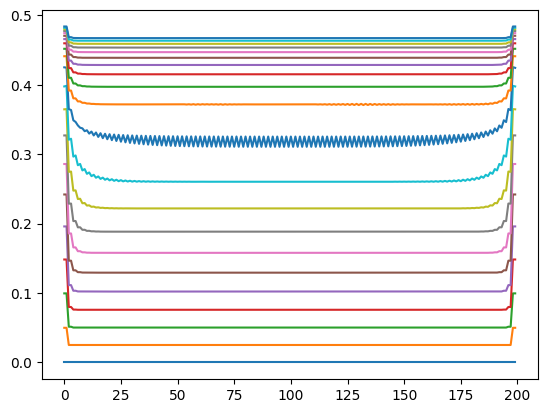

In [43]:
for l in x_exps:
    plt.plot(l)

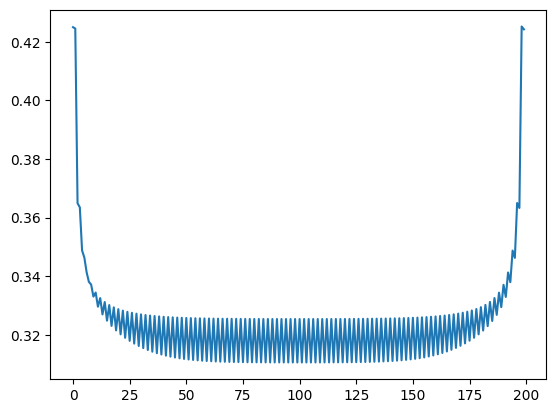

In [44]:
plt.plot(x_exps[10])

In [45]:
psi_dict[0.5].expectation_value_multi_sites(['Sx', 'Id', 'Id', 'Sx'], 99)

array(0.01672522)

In [46]:
def get_two_point_x_expectation(psi, distance):
    ops = ['Sx',] + ['Id',]*(distance-1) + ['Sx']

    return psi.expectation_value_multi_sites(ops, 80)

In [47]:
x_2_points = np.array([
    [get_two_point_x_expectation(psi, d) for d in range(41)]
    for psi in psi_dict.values()
])

In [48]:
x_2_points.shape

(21, 41)

In [49]:
sub_x_exps = x_exps[:,80:121]

In [50]:
sub_x_exps.shape

(21, 41)

In [51]:
x_correlations = (
    x_2_points
    - x_exps[:,80:81]*x_exps[:,80:121]
)

In [52]:
x_correlations.shape

(21, 41)

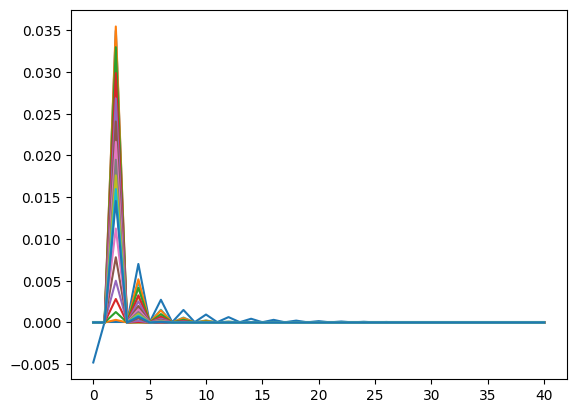

In [53]:
for l in x_correlations:
    plt.plot(l)

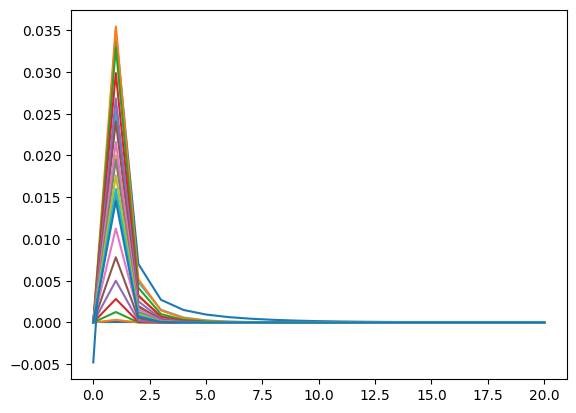

In [54]:
for l in x_correlations:
    plt.plot(l[::2])

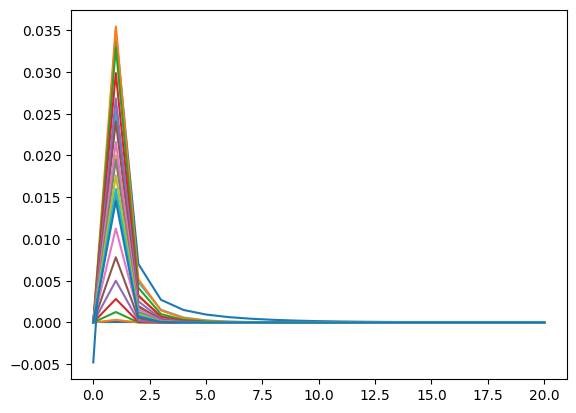

In [55]:
for l in x_correlations:
    plt.plot(l[::2])

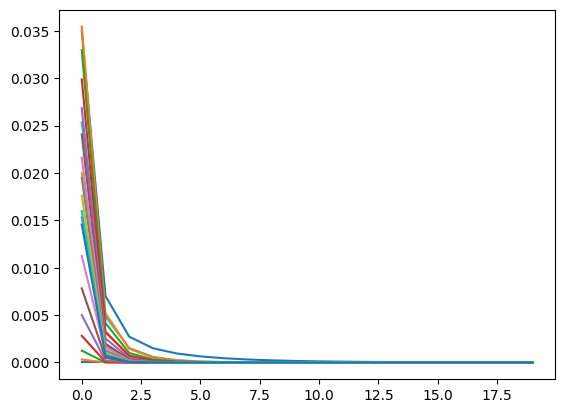

In [56]:
for l in x_correlations:
    plt.plot(l[2::2])

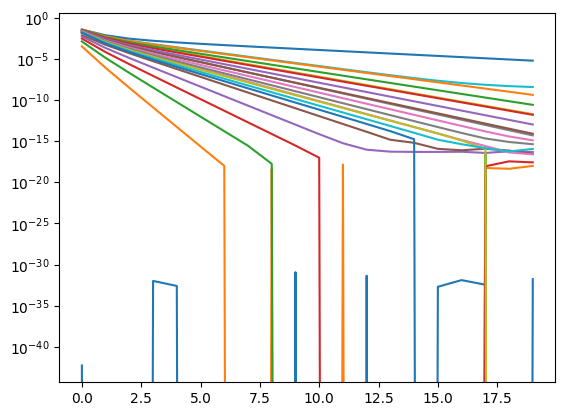

In [57]:
for l in x_correlations:
    plt.plot(l[2::2])

plt.yscale('log')

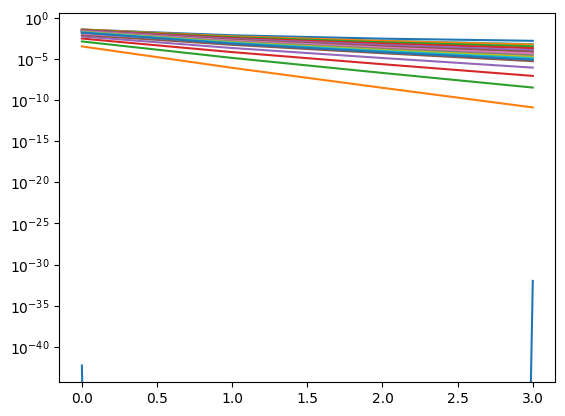

In [58]:
for l in x_correlations:
    plt.plot(l[2:10:2])

plt.yscale('log')

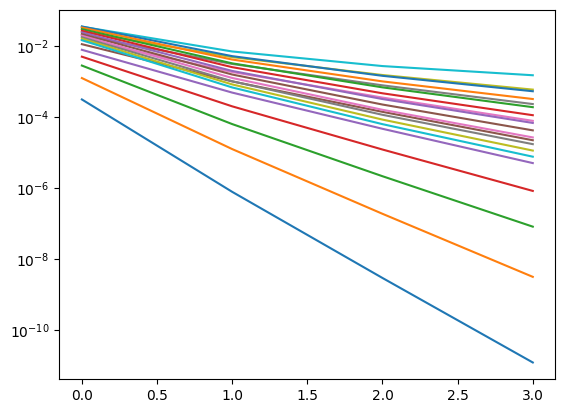

In [59]:
for l in x_correlations[1:]:
    plt.plot(l[2:10:2])

plt.yscale('log')

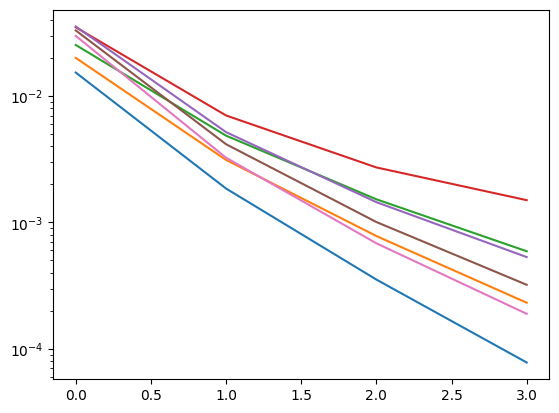

In [60]:
for l in x_correlations[7:14]:
    plt.plot(l[2:10:2])

plt.yscale('log')

In [61]:
np.log(x_correlations[10,2]/x_correlations[10,8])

3.148510758100284

In [62]:
correlation_lengths = 6/np.log(x_correlations[:,2]/x_correlations[:,8])

In [63]:
correlation_lengths[0] = 0

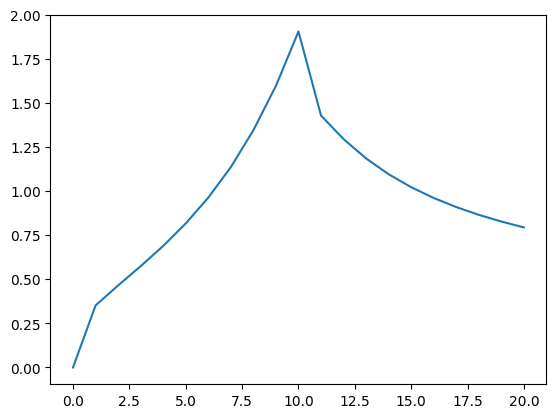

In [64]:
plt.plot(correlation_lengths)

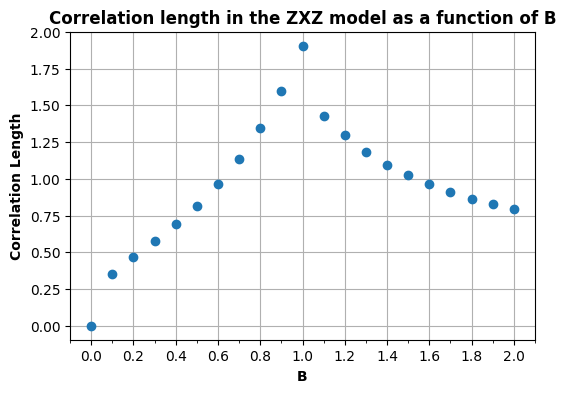

In [78]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    psi_dict.keys(),
    correlation_lengths,
    'o'
)

ax.grid()

ax.set_xticks(np.array(list(psi_dict.keys())))

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlabel("B", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.set_title("Correlation length in the ZXZ model as a function of B", fontweight='bold')

fig.savefig(r'plots/correlation_length_zxz_model.png', dpi=200)

In [81]:
with open(r'make_plots/data/200_site_mps_correlation_lengths.pkl', 'wb') as f:
    pickle.dump(
        {
            'b_parameters': list(psi_dict.keys()),
            'correlation_lengths': correlation_lengths
        },
        f
    )

In [66]:
x_correlations.shape

(21, 41)

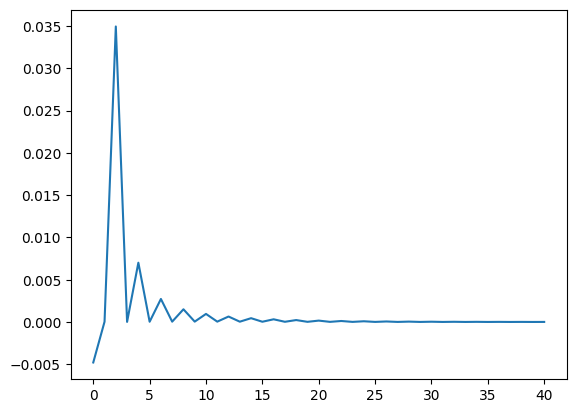

In [67]:
plt.plot(x_correlations[10])

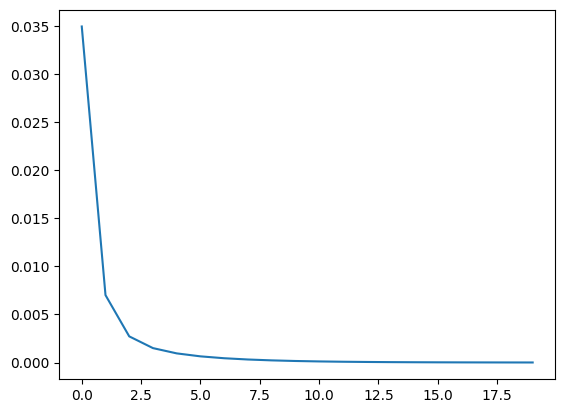

In [68]:
plt.plot(x_correlations[10,2::2])

In [69]:
test_corr_length = correlation_lengths[10]

In [70]:
a = x_correlations[10, 2]

In [71]:
test_data = [
    a*np.exp(-i/test_corr_length) for i in range(40)
]

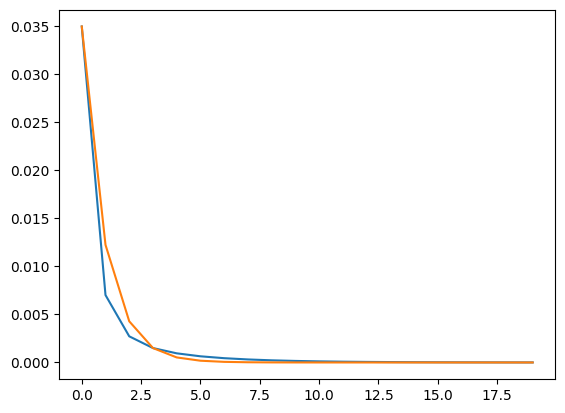

In [72]:
plt.plot(x_correlations[10,2::2])
plt.plot(test_data[::2])

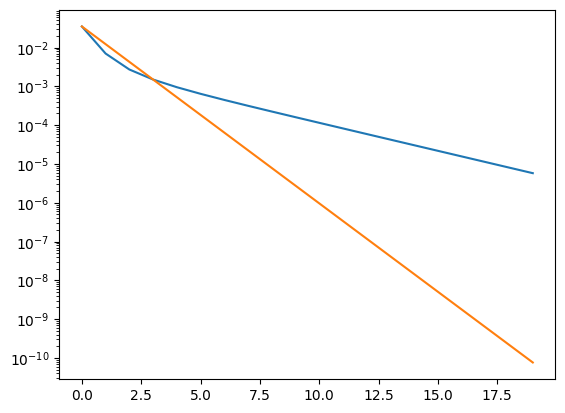

In [73]:
plt.plot(x_correlations[10,2::2])
plt.plot(test_data[::2])

plt.yscale('log')

In [74]:
def find_correlation_length(correlations, threshold=1e-13):
    values = [c for c in correlations if c > threshold]

    if len(values) > 10:
        values = values[-10:]

    corr_length = len(values)/np.log(values[0]/values[-1])

    return corr_length

In [75]:
x_correlations[0]

array([-3.19319185e-30,  4.24957801e-30,  5.72430423e-43,  1.88811230e-32,
       -2.15609067e-32, -1.43938251e-31, -1.91869547e-33,  1.87804685e-32,
        1.05519162e-32, -2.93899879e-32,  2.60186512e-33,  2.30366933e-32,
       -7.71554934e-42,  3.28744535e-32, -2.91192049e-33, -9.79241155e-33,
       -3.29209371e-32,  2.44469134e-33, -7.06254426e-43,  5.03977537e-32,
        1.21148067e-31,  5.99366934e-35, -1.97136999e-32, -8.77933548e-33,
       -5.18758164e-33,  3.20830517e-34,  4.53644256e-32, -9.92746107e-33,
       -4.84084227e-33,  1.20695925e-33, -3.96458613e-32,  8.38206644e-32,
        2.03915021e-33, -2.74863248e-32,  1.32232953e-32,  1.04933195e-33,
        3.65793636e-33, -2.56712244e-32, -9.12300369e-32,  3.68456425e-34,
        1.73514424e-32])

In [76]:
adjusted_corr_lengths = [0,] + [
    2*find_correlation_length(l[2::2]) for l in x_correlations[1:]
]

Text(0.5, 1.0, 'Correlation length in the ZXZ model as a function of B')

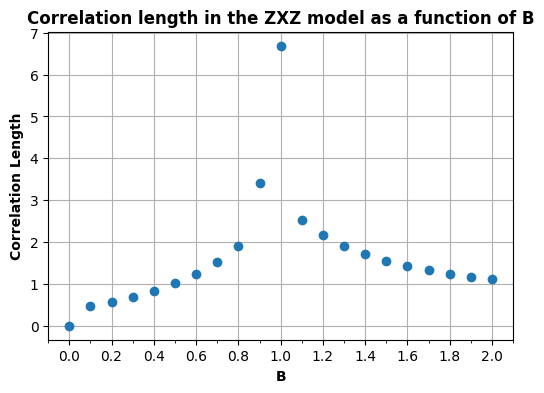

In [77]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    psi_dict.keys(),
    adjusted_corr_lengths,
    'o'
)

ax.grid()

ax.set_xticks(np.array(list(psi_dict.keys())))

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlabel("B", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.set_title("Correlation length in the ZXZ model as a function of B", fontweight='bold')